In [1]:
%load_ext autoreload
%autoreload 2
import warnings
import numpy as np
import torch

import random
import sys
import pandas as pd

sys.path.append("..")

warnings.filterwarnings('ignore') # ignore warnings

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Set seeds for reproducibility
seed = 82718
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


## Experiment with Hillstrom

Here, we load two experiments from Hillstrom: $(i)$ advertising men's merchandise vs. no advertisement, and it's effect on whether or not a user visit's the website, and $(ii)$ advertising women's merchandise vs. no advertisement, and it's effect on whether or not a user visit's the website. Run the following to load the datasets:


In [2]:
%autoreload 2
from benchmarks import HillstromDataset

hill1 = HillstromDataset(
    seed=seed,
    n_folds=5,
    outcome_col="visit",
    control_arm = "No E-Mail",
    treatment_arm= "Womens E-Mail",
)
hill2 = HillstromDataset(
    seed=seed,
    n_folds=5,
    outcome_col="visit",
    control_arm = "No E-Mail",
    treatment_arm= "Mens E-Mail",
)

Now run the following which will estimate the effect of every unit using 5-fold honest splitting. It will estimate the effects using both an X-Learner, as well as our CausalPFN:

In [3]:
%autoreload 2
from causalpfn.causal_estimator import CATEEstimator
from benchmarks.base import Qini_Dataset
from tqdm import tqdm
from benchmarks.baselines import XLearnerBaseline

datasets = [hill1, hill2]
results = [
    pd.DataFrame(columns=['y', 't', 'effect_causalpfn', 'effect_xlearner']),
    pd.DataFrame(columns=['y', 't', 'effect_causalpfn', 'effect_xlearner']),
]
pbar = tqdm(
    total = sum([len(dset) for dset in datasets]),
    desc = "Running CausalPFN and X-Learner",
)
for dset_idx in range(len(datasets)):
    dset: HillstromDataset = datasets[dset_idx]
    for fold_idx in range(len(dset)):
        # fit on the rest of the data and get estimates for the current fold (honest splitting)
        qini_data: Qini_Dataset = dset[fold_idx]
        train_size = qini_data.X_train.shape[0]
        test_size = qini_data.X_test.shape[0]
        # run causalpfn
        causalpfn = CATEEstimator(
            device=device,
            max_context_length=train_size, # set to a large value to fit everything in the context
        )
        causalpfn.fit(X=qini_data.X_train, y=qini_data.y_train, t=qini_data.t_train)
        causalpfn_tau_hat = causalpfn.estimate_cate(X=qini_data.X_test)

        # run an x-learner
        xlearner = XLearnerBaseline(hpo=False)
        xlearner_tau_hat = xlearner.estimate_cate(
            X_train=qini_data.X_train,
            y_train=qini_data.y_train,
            t_train=qini_data.t_train,
            X_test=qini_data.X_test,
        )

        # add the fold
        results[dset_idx] = pd.concat([results[dset_idx], pd.DataFrame({
            'y': qini_data.y_test,
            't': qini_data.t_test,
            'effect_causalpfn': causalpfn_tau_hat,
            'effect_xlearner': xlearner_tau_hat,
        })], ignore_index=True)
        pbar.update(1)
pbar.close()


rpy2 not installed, skipping BART baseline.
catenets not installed, skipping CATENet baselines.
rpy2 not installed, skipping GRF baseline.


Running CausalPFN and X-Learner: 100%|██████████| 10/10 [06:38<00:00, 39.80s/it]


In [4]:
results[1].head()

,y,t,effect_causalpfn,effect_xlearner
0,0.0,1.0,0.031093,0.084518
1,0.0,0.0,0.080992,0.080111
2,0.0,1.0,0.144844,0.068872
3,0.0,1.0,-0.002843,0.057735
4,0.0,1.0,0.130926,0.130647


## Visualize the Qini Curves

Once the results are saved, run the following to visualize the Qini curves for both of the randomized trials. The men's merchandise experiment should show a smaller lift compared to the women's merchandise experiment.


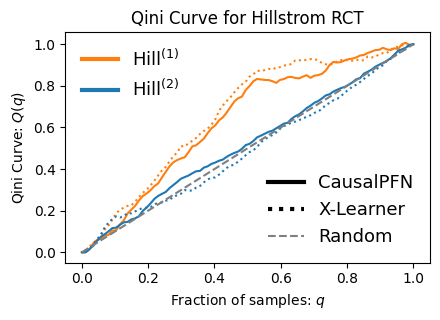

In [5]:
from src.causalpfn.evaluation import get_qini_curve
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(4.5, 3.3))
qini_curves = []
STEP = 500

orange = "#FF7F0E"  # Hill(1): email vs no‑email
blue = "#1f77b4"  # Hill(2): women vs men email
grey = "#7f7f7f"  # random baseline

for dset_idx in range(len(datasets)):
    all_t = results[dset_idx]["t"].values
    all_y = results[dset_idx]["y"].values
    all_effects_causalpfn = results[dset_idx]["effect_causalpfn"].values
    all_effects_xlearner = results[dset_idx]["effect_xlearner"].values

    curve_causalpfn, score_causalpfn = get_qini_curve(
        rct_treatments=all_t,
        rct_outcomes=all_y,
        estimated_cate=all_effects_causalpfn,
        normalize=True,
    )
    curve_xlearner, score_xlearner = get_qini_curve(
        rct_treatments=all_t,
        rct_outcomes=all_y,
        estimated_cate=all_effects_xlearner,
        normalize=True,
    )
    curve_causalpfn = np.r_[curve_causalpfn[0], curve_causalpfn[::STEP], curve_causalpfn[-1]]
    curve_xlearner = np.r_[curve_xlearner[0], curve_xlearner[::STEP], curve_xlearner[-1]]
    color = orange if dset_idx == 0 else blue
    ax.plot(np.linspace(0, 1, len(curve_causalpfn)), curve_causalpfn, label=f"CausalPFN {dset_idx+1}", color=color)
    ax.plot(
        np.linspace(0, 1, len(curve_xlearner)),
        curve_xlearner,
        label=f"X-Learner {dset_idx+1}",
        color=color,
        linestyle=":",
    )
ax.plot([0, 1], [0, 1], linestyle="--", label="Random", color=grey)
ax.set_title(f"Qini Curve for Hillstrom RCT")
ax.legend()
ax.set_xlabel("Fraction of samples: $q$")
ax.set_ylabel("Qini Curve: $Q(q)$")


colour_legend = [
    Line2D([0], [0], color=orange, lw=3, label="Hill$^{(1)}$"),
    Line2D([0], [0], color=blue, lw=3, label="Hill$^{(2)}$"),
]
style_legend = [
    Line2D([0], [0], color="black", lw=3, ls="-", label="CausalPFN"),
    Line2D([0], [0], color="black", lw=3, ls=":", label="X-Learner"),
    Line2D([0], [0], color=grey, lw=1.5, ls="--", label="Random"),
]
first = ax.legend(handles=colour_legend, loc="upper left", frameon=False, fontsize=13)
second = ax.legend(handles=style_legend, loc="lower right", frameon=False, fontsize=13)
ax.add_artist(first)  # keep the first legend
plt.tight_layout()
plt.show()